# Deep Learning Homework 2: K-Nearest Neighbors (k-NN)

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [49]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['knn.py', 'knn.ipynb', 'usefuns']
```

In [50]:
"""import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a DL2022 folder and put all the files under HW2 folder, then 'DL2022/HW2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL2022/HW2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'None'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))"""

"import os\n\n# TODO: Fill in the Google Drive path where you uploaded the assignment\n# Example: If you create a DL2022 folder and put all the files under HW2 folder, then 'DL2022/HW2'\n# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL2022/HW2'\nGOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'None'\nGOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)\nprint(os.listdir(GOOGLE_DRIVE_PATH))"

Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from knn.py!
```

as well as the last edit time for the file `pytorch101.py`.

In [51]:
"""import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "CUT"
time.tzset()

from knn import hello
hello()

knn_path = os.path.join(GOOGLE_DRIVE_PATH, 'knn.py')
knn_edit_time = time.ctime(os.path.getmtime(knn_path))
print('knn.py last edited on %s' % knn_edit_time)"""

'import sys\nsys.path.append(GOOGLE_DRIVE_PATH)\n\nimport time, os\nos.environ["TZ"] = "CUT"\ntime.tzset()\n\nfrom knn import hello\nhello()\n\nknn_path = os.path.join(GOOGLE_DRIVE_PATH, \'knn.py\')\nknn_edit_time = time.ctime(os.path.getmtime(knn_path))\nprint(\'knn.py last edited on %s\' % knn_edit_time)'

# Data preprocessing / Visualization

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [52]:

from usefuns import data
from usefuns import vis
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Load the CIFAR-10 dataset
The utility function `tools.data.cifar10()` returns the entire CIFAR-10 dataset as a set of four **Torch tensors**:

- `x_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `x_test` contains all test images
- `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [53]:
x_train, y_train, x_test, y_test = data.cifar10() 

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


## Visualize the dataset
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

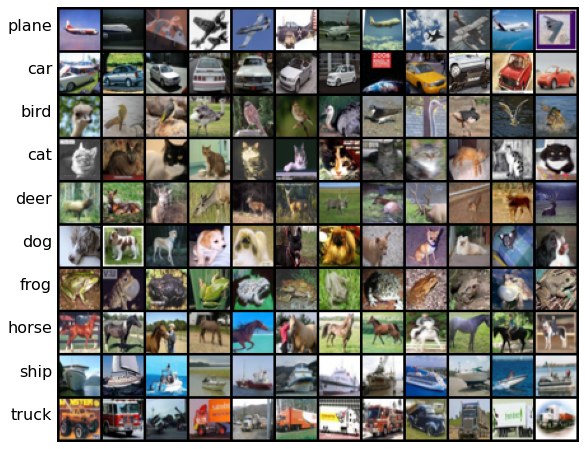

In [54]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(vis.tensor_to_image(img))  
plt.axis('off')
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

The function `tools.data.cifar10()` can automatically subsample the CIFAR10 dataset for us. To see how to use it, we can check the documentation using the built-in `help` command:

In [55]:
help(data.cifar10) 

Help on function cifar10 in module usefuns.data:

cifar10(num_train=None, num_test=None)
    Return the CIFAR10 dataset, automatically downloading it if necessary.
    This function can also subsample the dataset.
    
    Inputs:
    - num_train: [Optional] How many samples to keep from the training set.
      If not provided, then keep the entire training set.
    - num_test: [Optional] How many samples to keep from the test set.
      If not provided, then keep the entire test set.
    
    Returns:
    - x_train: float32 tensor of shape (num_train, 3, 32, 32)
    - y_train: int64 tensor of shape (num_train, 3, 32, 32)
    - x_test: float32 tensor of shape (num_test, 3, 32, 32)
    - y_test: int64 tensor of shape (num_test, 3, 32, 32)



We will subsample the data to use only 500 training examples and 100 test examples:

In [56]:
num_train = 500
num_test = 250

x_train, y_train, x_test, y_test = data.cifar10(num_train, num_test)  

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([500, 3, 32, 32])
  labels shape:  torch.Size([500])
Test set:
  data shape:  torch.Size([250, 3, 32, 32])
  labels shape torch.Size([250])


# K-Nearest Neighbors (k-NN)

## Compute distances: Naive implementation
Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Compute the (squared Euclidean) distances between all training examples and all test examples
2. Given these distances, for each test example find its k nearest neighbors and have them vote for the label to output

Lets begin with computing the distance matrix between all training and test examples. First we will implement a naive version of the distance computation, using explicit loops over the training and test sets. In the file `knn.py`, implement the function `compute_distances_two_loops`.

**NOTE: When implementing distance functions for this assignment, you may not use functions `torch.norm` or `torch.dist` (or their instance method variants `x.norm` / `x.dist`); you may not use any functions from `torch.nn` or `torch.nn.functional`.**

In [57]:
from knn import compute_distances_two_loops

torch.manual_seed(0)
num_train = 500
num_test = 250
x_train, y_train, x_test, y_test = data.cifar10(num_train, num_test) 

dists = compute_distances_two_loops(x_train, x_test)
        
print('dists has shape: ', dists.shape)

dists has shape:  torch.Size([500, 250])


As a visual debugging step, we can visualize the distance matrix, where each row is a test example and each column is a training example.

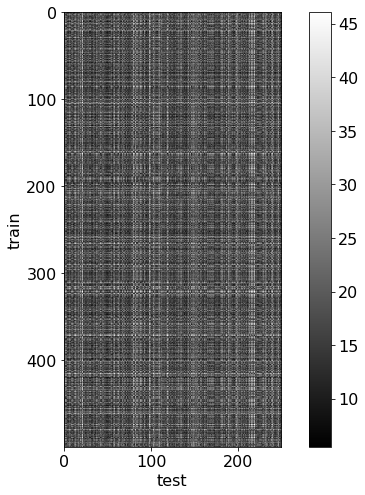

In [58]:
plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

## Compute distances: Vectorization
Our implementation of the distance computation above is fairly inefficient since it uses nested Python loops over the training and test sets.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

The process of eliminating explict loops from your code is called **vectorization**. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our distance computation function.

As a first step toward vectorizing our distance computation, you will implement a version that uses only a single Python loop over the training data. In the file `knn.py`, complete the implementation of the function `compute_distances_one_loop`.

We can check the correctness of our one-loop implementation by comparing it with our two-loop implementation on some randomly generated data.

Note that we do the comparison with 64-bit floating points for increased numeric precision.

In [59]:
from knn import compute_distances_one_loop
from knn import compute_distances_two_loops

torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)


print("dists_one=\n", dists_one)
difference = (dists_one - dists_two).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
    print('Good! The distance matrices match')
else:
    print('Uh-oh! The distance matrices are different')

dists_one=
 tensor([[39.3161, 39.8118, 40.3103,  ..., 41.0242, 38.2984, 39.5875],
        [38.8819, 37.3689, 38.1309,  ..., 38.4526, 39.5302, 37.9611],
        [38.7818, 40.5407, 39.4446,  ..., 40.0087, 40.9317, 37.0953],
        ...,
        [37.8070, 38.6569, 39.4628,  ..., 40.0468, 38.7290, 39.0430],
        [38.0166, 38.4215, 39.3562,  ..., 38.8966, 39.9505, 38.2432],
        [38.3346, 38.4390, 38.6731,  ..., 40.4090, 39.2826, 38.4662]],
       dtype=torch.float64)
Difference:  0.0
Good! The distance matrices match


You will now implement a fully vectorized version of the distance computation function
that does not use any Python loops. In the file `knn.py`, implement the function `compute_distances_no_loops`.

As before, we can check the correctness of our implementation by comparing the fully vectorized version against the original naive version:

In [60]:
from knn import compute_distances_two_loops
from knn import compute_distances_no_loops

torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)

difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  3.4518046167849885e-13
Good! The distance matrices match


We can now compare the speed of our three implementations. If you've implemented everything properly, the one-loop implementation should take less than 4 seconds to run, and the fully vectorized implementation should take less than 0.1 seconds to run.

In [61]:
import time
from knn import compute_distances_two_loops
from knn import compute_distances_one_loop
from knn import compute_distances_no_loops

def timeit(f, *args):
    tic = time.time()
    f(*args) 
    toc = time.time()
    return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print('Two loop version took %.2f seconds' % two_loop_time)

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print('One loop version took %.2f seconds (%.1fX speedup)'
      % (one_loop_time, speedup))

no_loop_time = timeit(compute_distances_no_loops, x_train_rand, x_test_rand)
speedup = two_loop_time / no_loop_time
print('No loop version took %.2f seconds (%.1fX speedup)'
      % (no_loop_time, speedup))

Two loop version took 2.87 seconds
One loop version took 0.26 seconds (11.2X speedup)
No loop version took 0.01 seconds (398.1X speedup)


## Predict labels
Now that we have a method for computing distances between training and test examples, we need to implement a function that uses those distances together with the training labels to predict labels for test samples.

In the file `knn.py`, implement the function `predict_labels`.

In [62]:
from knn import predict_labels

torch.manual_seed(0)
dists = torch.tensor([
    [0.3, 0.4, 0.1],
    [0.1, 0.5, 0.5],
    [0.4, 0.1, 0.2],
    [0.2, 0.2, 0.4],
    [0.5, 0.3, 0.3],
])
y_train = torch.tensor([0, 1, 0, 1, 2])
y_pred_expected = torch.tensor([1, 0, 0])
y_pred = predict_labels(dists, y_train, k=3)
correct = y_pred.tolist() == y_pred_expected.tolist()
print('Correct: ', correct)

Correct:  True


Now we have implemented all the required functionality for the K-Nearest Neighbor classifier. In the file `knn.py`, complete the implementation of the `KnnClassifer` class.

We can get some intuition into the KNN classifier by visualizing its predictions on toy 2D data. Here we will generate some random training and test points in 2D, and assign random labels to the training points. We can then make predictions for the test points, and visualize both training and test points. Training points are shown as stars, and tet points are shown as small transparent circles. The color of each point denots its label -- ground-truth label for training points, and predicted label for test points.

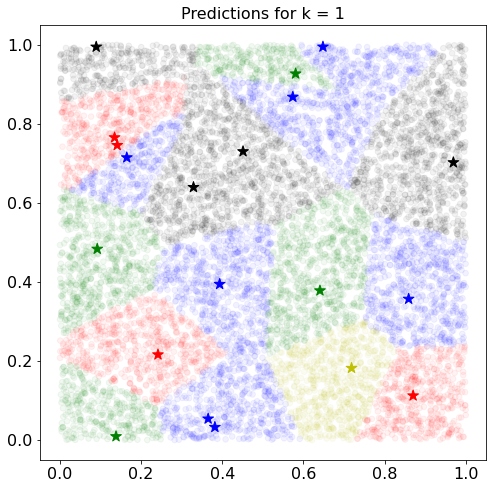

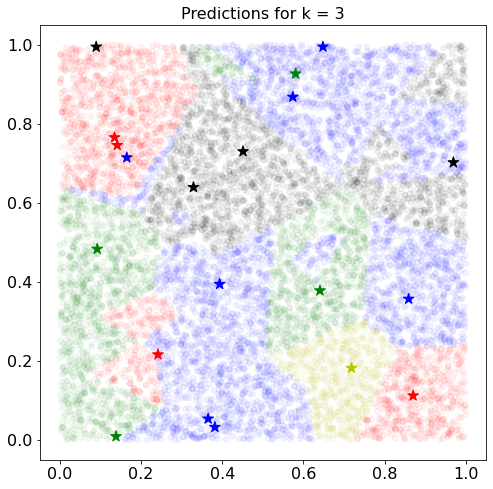

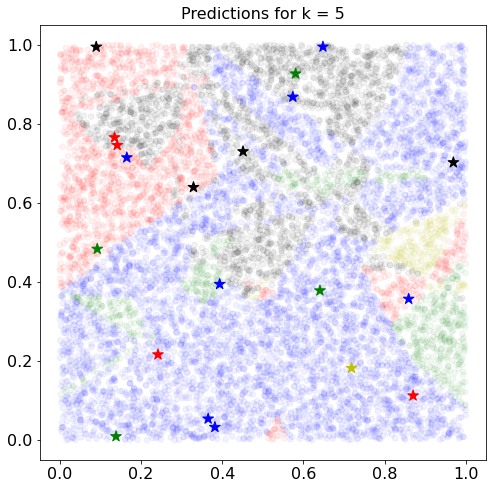

In [63]:
from knn import KnnClassifier

num_test = 10000
num_train = 20
num_classes = 5

# Generate random training and test data
torch.manual_seed(128)
x_train = torch.rand(num_train, 2)
y_train = torch.randint(num_classes, size=(num_train,))
x_test = torch.rand(num_test, 2)
classifier = KnnClassifier(x_train, y_train)

# Plot predictions for different values of k
for k in [1, 3, 5]:
    y_test = classifier.predict(x_test, k=k)
    plt.gcf().set_size_inches(8, 8)
    class_colors = ['r', 'g', 'b', 'k', 'y']
    train_colors = [class_colors[c] for c in y_train]
    test_colors = [class_colors[c] for c in y_test]
    plt.scatter(x_test[:, 0], x_test[:, 1],
                color=test_colors, marker='o', s=32, alpha=0.05)
    plt.scatter(x_train[:, 0], x_train[:, 1],
                color=train_colors, marker='*', s=128.0)
    plt.title('Predictions for k = %d' % k, size=16)
    plt.show()

We can use the exact same KNN code to perform image classification on CIFAR-10!

Now lets put everything together and test our K-NN clasifier on a subset of CIFAR-10, using k=1:

If you've implemented everything correctly you should see an accuracy of about 27%.

In [64]:
from knn import KnnClassifier

torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = data.cifar10(num_train, num_test) 

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 137 / 500 correct; accuracy is 27.40%


27.4

Now lets increase to k=5. You should see a slightly higher accuracy than k=1:

In [65]:
from knn import KnnClassifier

torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = data.cifar10(num_train, num_test) 

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=5)

Got 144 / 500 correct; accuracy is 28.80%


28.8

## Cross-validation
We have not implemented the full k-Nearest Neighbor classifier, but the choice of $k=5$ was arbitrary. We will use **cross-validation** to set this hyperparameter in a more principled manner.

In the file `knn.py`, implement the function `knn_cross_validate` to perform cross-validation on k.

In [ ]:
from knn import knn_cross_validate

torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = data.cifar10(num_train, num_test)  

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

In [ ]:
ks, means, stds = [], [], []
torch.manual_seed(0)
for k, accs in sorted(k_to_accuracies.items()):
  plt.scatter([k] * len(accs), accs, color='g')
  ks.append(k)
  means.append(statistics.mean(accs))
  stds.append(statistics.stdev(accs))
plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

Now we can use the results of cross-validation to select the best value for k, and rerun the classifier on our full 5000 set of training examples.

You should get an accuracy above 28%.

In [ ]:
from knn import KnnClassifier
from knn import knn_get_best_k

best_k = 1
torch.manual_seed(0)

best_k = knn_get_best_k(k_to_accuracies)    
print('Best k is ', best_k)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Finally, we can use our chosen value of k to run on the entire training and test sets.

This may take a while to run, since the full training and test sets have 50k and 10k examples respectively. You should get an accuracy above 33%.

**Run this only once!**

In [ ]:
from knn import KnnClassifier

torch.manual_seed(0)
x_train_all, y_train_all, x_test_all, y_test_all = data.cifar10() 
classifier = KnnClassifier(x_train_all, y_train_all)
classifier.check_accuracy(x_test_all, y_test_all, k=best_k)